In [7]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson, quad
from scipy.special import spherical_jn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic, ExpSineSquared, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Constants

In [8]:
# Pb-208
R = 6.65
a = 0.526
Z = 82
# Au
R1 = 6.63
a1 = 0.45
Z1 = 79
hbarc = 197.327 # MeV fm
# ----------------
E1 = 126 # MeV
E2 = 183 # MeV
e_constant = 18.095 # e^2 / ε0 MeV fm

## Charge Density Distribution

In [9]:
def rho_dist(r,rho0,R,a):
    return rho0 / (1 + np.exp((r - R) / a))

## Normalization

In [10]:
# Spherical integration (r^2 dr dΩ)
def normalized_rho_dist(R, a, Z):
    
    # Integrand for normalization calculation
    def integrand(r):
        return 4 * np.pi * r**2 * rho_dist(r, 1.0,R,a)  # Using rho0=1 temporarily
    
    # Calculate normalization integral
    I_result, _ = quad(integrand, 0, np.inf)
    
    # Compute normalization constant
    rho0_val = Z / I_result
    
    # Create normalized function
    def norm_rho_dist(r):
        return rho_dist(r, rho0_val,R,a)
    
    return norm_rho_dist, rho0_val

rho_norm, rho0 = normalized_rho_dist(R,a,Z)

# Verification prints
print(f"Normalization constant ρ0 = {rho0:.6f} e/fm^3")

# Verify integral equals Z
integral = quad(lambda r: 4*np.pi*r**2*rho_norm(r), 0, np.inf)[0]
print(f"Verification: Integral of normalized ρ_dist = {integral:.2f} (should be {Z})\n")

# Check characteristic points
print(f"ρ(R) = {rho_norm(6.63):.6f} e/fm^3 (should be ρ0/2 = {rho0/2:.6f})")
print(f"ρ(0) = {rho_norm(0):.6f} e/fm^3 (maximum density)")
print(f"ρ(2R) = {rho_norm(2*6.63):.6f} e/fm^3 (far tail)")

Normalization constant ρ0 = 0.062696 e/fm^3
Verification: Integral of normalized ρ_dist = 82.00 (should be 82)

ρ(R) = 0.031944 e/fm^3 (should be ρ0/2 = 0.031348)
ρ(0) = 0.062696 e/fm^3 (maximum density)
ρ(2R) = 0.000000 e/fm^3 (far tail)


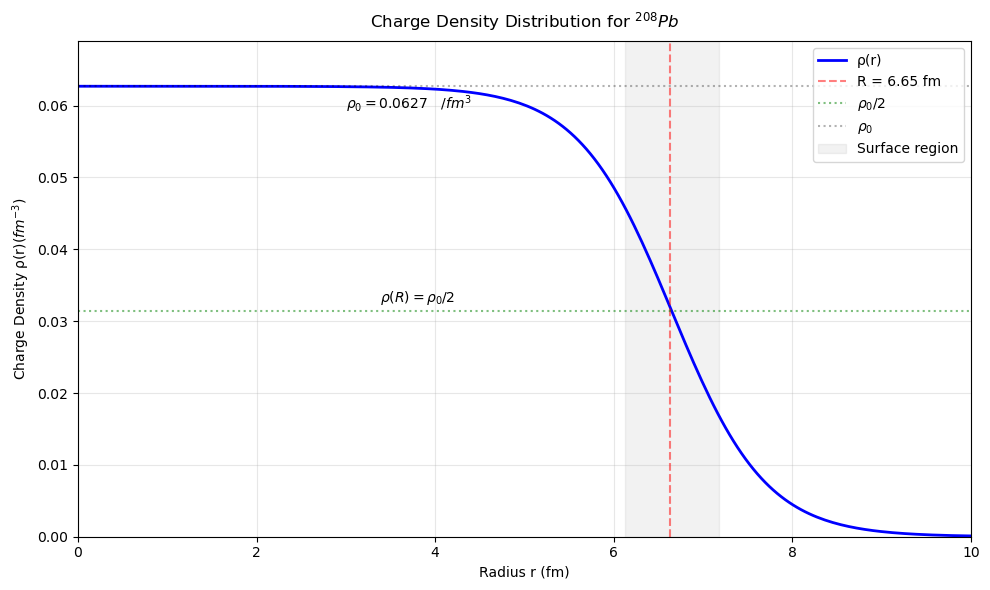

In [11]:
plt.figure(figsize=(10, 6))

# Generate radial points (0 to 3R for good visualization)
r_values = np.linspace(0, 2*R, 300)
rho_values = rho_norm(r_values)


plt.plot(r_values, rho_values, 'b-', linewidth=2, label='ρ(r)')
plt.axvline(6.63, color='r', linestyle='--', alpha=0.5, label=f'R = {R} fm')
plt.axhline(rho0/2, color='g', linestyle=':', alpha=0.5, label=r'$\rho_0/2$')
plt.axhline(rho0, color='k', linestyle=':', alpha=0.3, label=r'$\rho_0$')

# surface diffuseness region
plt.axvspan(R-a, R+a, color='gray', alpha=0.1, label='Surface region')
plt.title(r'Charge Density Distribution for $^{208}Pb$', pad=10)
plt.xlabel('Radius r (fm)')
plt.ylabel(r'Charge Density ρ(r)($fm^{-3}$)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, rho0*1.1)
plt.text(3.8, rho0*0.51, r'$\rho(R) = \rho_0/2$', ha='center', va='bottom')
plt.text(3, rho0*0.95, fr'$\rho_0 = {rho0:.4f} \quad /fm^3 $', ha='left')
plt.tight_layout()
plt.show()

## Compute main integral

q [/fm]	F(q)
0.00		81.921160
0.06		80.382753
0.12		75.899583
0.18		68.852114
0.24		59.824449
0.31		49.536916
0.37		38.765552
0.43		28.259567
0.49		18.667589
0.55		10.481635
0.61		4.004578
0.67		-0.656919
0.73		-3.575773
0.80		-4.969103
0.86		-5.151082
0.92		-4.481762
0.98		-3.319111
1.04		-1.979950
1.10		-0.713335
1.16		0.312416
1.22		1.009997
1.29		1.363210
1.35		1.410339
1.41		1.224478
1.47		0.894112
1.53		0.506484
1.59		0.135327
1.65		-0.166452
1.71		-0.369339
1.78		-0.465838
1.84		-0.466307
1.90		-0.393221
1.96		-0.275029
2.02		-0.140550
2.08		-0.014564
2.14		0.085049
2.20		0.148518
2.27		0.173921
2.33		0.165778
2.39		0.132939
2.45		0.086236
2.51		0.036305
2.57		-0.008096
2.63		-0.041096
2.69		-0.060026
2.76		-0.065116
2.82		-0.058777
2.88		-0.044681
2.94		-0.026851
3.00		-0.008918


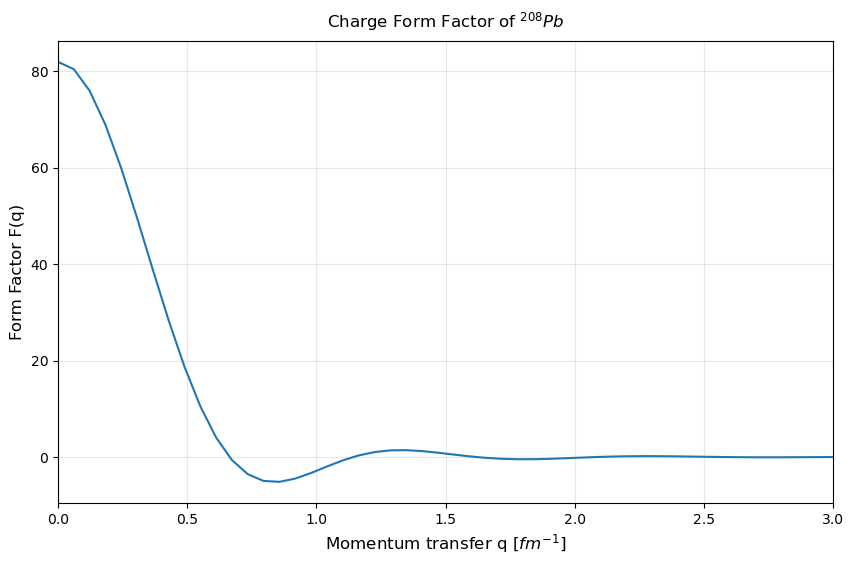

In [12]:
def rho_ch(r, R=R, a=a, Z=Z):
    # Calculate normalization constant ρ0
    def integrand(r):
        return 4 * np.pi * r**2 / (1 + np.exp((r - R)/a))
    integral, _ = quad(integrand, 0, np.inf)
    rho0 = Z / integral
    return rho0 / (1 + np.exp((r - R)/a))

def form_factor(q, r_max=10.0):
    def integrand(r):
        return 4 * np.pi * r**2 * rho_ch(r) * spherical_jn(0, q*r)
    result, _ = quad(integrand, 0, r_max)
    return result



q_values = np.linspace(0, 3, 50)  # q-range [fm^-1]
Fq_values = [form_factor(q) for q in q_values]

print("q [/fm]\tF(q)")
for q, Fq in zip(q_values, Fq_values):
    print(f"{q:.2f}\t\t{Fq:.6f}")

plt.figure(figsize=(10, 6))
plt.plot(q_values, Fq_values)
plt.xlabel(r'Momentum transfer q [$fm^{-1}$]', fontsize=12)
plt.ylabel('Form Factor F(q)', fontsize=12)
plt.title(r'Charge Form Factor of $^{208}Pb$', pad=10)
plt.xlim(0,3)
plt.grid(True, alpha=0.3)
plt.show()

Text(0.5, 1.0, 'Cross-Section of $^{197}Au$')

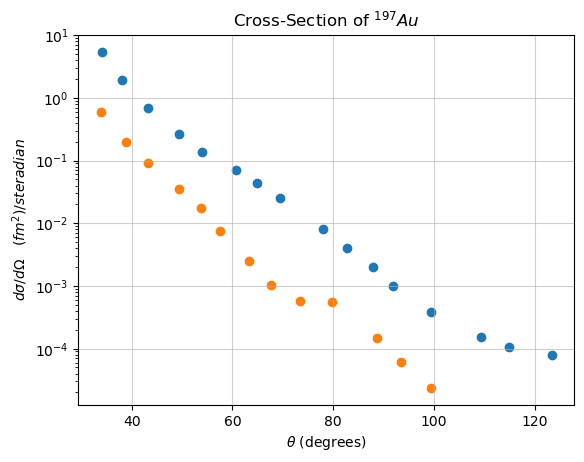

In [13]:
dataset = pd.read_csv("cross_section_data.csv")
data1 = dataset[dataset["E"] == 126]
data2 = dataset[dataset["E"] == 183]

plt.figure()
plt.scatter(data1["deg"],data1["cs"])
plt.scatter(data2["deg"],data2["cs"])
plt.yscale('log')
plt.grid(alpha=0.6)
plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel(r"$d\sigma /d\Omega \quad(fm^2)/steradian$")
plt.title(r"Cross-Section of $^{197}Au$")

In [14]:

def calculate_cs(Z, R, a, E, theta, hbarc=hbarc):
    # Normalization constant
    rho0 = normalized_rho_dist(R, a, Z)[1]
    q = 2 * E * np.sin(theta/2) / hbarc
    const = (2*np.pi)**2 * E**2 * (1/(hbarc))**2 * (1/q)**4 * 4*a**2

    # Simpson integration grid
    r = np.linspace(0.1, 15, 500)
    integrand = rho_dist(r, rho0, R, a) * r**2 * 2 * np.sin(q*r) / (q*r)
    result = simpson(integrand, r)

    result = const * result**2
    return result

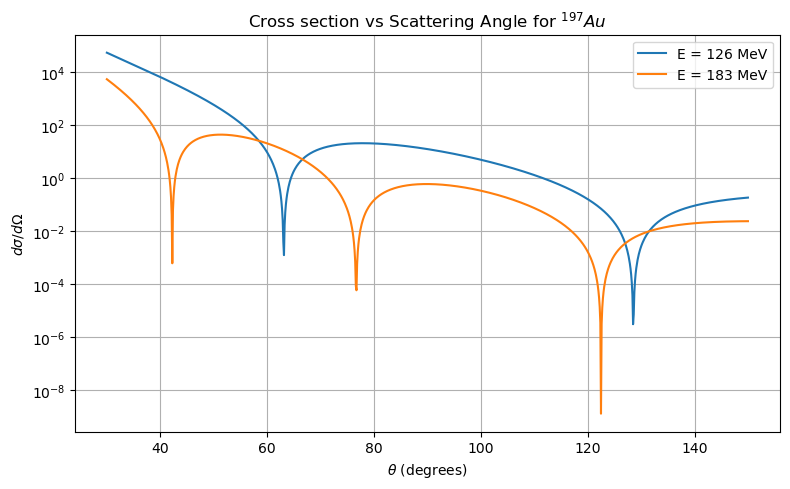

In [26]:
deg = np.linspace(30,150, 1000)
deg_rad = np.radians(deg)

csv_data = []
plt.figure(figsize=(8, 5))

for E in [126,183]:
    cross_sections = []
    for theta in deg_rad:
        sigma = calculate_cs(Z=Z1, R=R1, a=a1, E=E, theta=theta)
        cross_sections.append(sigma)
        theta = np.degrees(theta)
        csv_data.append([theta, sigma, E])
    plt.plot(deg, cross_sections, label=f"E = {E} MeV")

plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$d\sigma/d\Omega$')
plt.title(r'Cross section vs Scattering Angle for $^{197}Au$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df = pd.DataFrame(csv_data, columns=['deg', 'cs', 'E'])
df.to_csv('cross_sections_calculated.csv', index=False)

# GPR

In [75]:
df1 = df[df['E']==126]
df2 = df[df['E']==183]

deg1 = df1["deg"].to_numpy().reshape(-1,1)
deg2 = df2["deg"].to_numpy().reshape(-1,1)

deg = df["deg"].to_numpy().reshape(-1,1)
cs1 = df1["cs"].to_numpy().reshape(-1,1)
cs2 = df2["cs"].to_numpy().reshape(-1,1)

    
X_train1, X_test1, y_train1, y_test1 = train_test_split(deg1,cs1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(deg2,cs2, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(deg1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

#deg2 = scaler.transform(deg2)

kernel1 = ConstantKernel() * RBF(length_scale=50.0) + ConstantKernel() * RationalQuadratic(length_scale=10.0, alpha=1.5) + \
ConstantKernel() * ExpSineSquared(length_scale=5.0, periodicity=15.0, periodicity_bounds=(10.0, 25.0)) + \
WhiteKernel(noise_level=0.1)

# ----
kernel2 = ConstantKernel() *  RBF(length_scale=24, length_scale_bounds=(1e-5, 2)) *\
RationalQuadratic(length_scale=1, alpha=0.5, length_scale_bounds=(1e-5, 2), alpha_bounds=(1e-05, 1000)) + \
 WhiteKernel(noise_level=0.7)

In [76]:
model1 = GaussianProcessRegressor(kernel=kernel1, n_restarts_optimizer=50)

model1.fit(X_train1, y_train1)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=50) + 1**2 * RationalQuadratic(alpha=1.5, length_scale=10) + 1**2 * ExpSineSquared(length_scale=5, periodicity=15) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=50)

In [77]:
y_pred1, sigma1 = model1.predict(X_test1, return_std=True)
X_train1 = scaler.inverse_transform(X_train1)
X_test1 = scaler.inverse_transform(X_test1)

mse1 = mean_squared_error(y_test1, y_pred1)
r21 = r2_score(y_test1, y_pred1)
print(f" R2: {round(r21,4)} \n mean_squared_error: {round(mse1,4)}")

 R2: 0.9864 
 mean_squared_error: 864430.7968


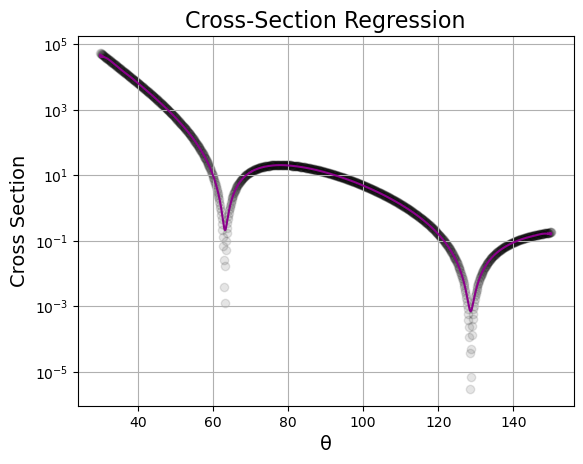

In [ ]:

deg_aug1 = np.linspace(min(deg1),max(deg1),4000)
deg_aug1 = deg_aug1.reshape(-1,1)
deg_aug1 = scaler.transform(deg_aug1)
y_pred_cs_aug1, sigma_cs_aug1 = model1.predict(deg_aug1, return_std=True)
deg_aug1 = scaler.inverse_transform(deg_aug1)

plt.figure()
plt.plot(deg_aug1, y_pred_cs_aug1,color='darkmagenta', linewidth=1.5, label='GPR Prediction')

#plt.fill_between(deg_aug1[:,0], y_pred_cs_aug1 - 1.96*sigma_cs_aug1,y_pred_cs_aug1 + 1.96*sigma_cs_aug1, alpha=0.6, color='plum', label='95% CI')
plt.scatter(deg1,cs1, color='black', edgecolor='black',alpha=0.1, label='Data')
#plt.xlim(min(deg1),max(deg1))
#plt.ylim(1.9,11)
plt.yscale('log')
plt.xlabel("θ", fontsize=14)
plt.ylabel("Cross Section",fontsize=14)
plt.title("Cross-Section Regression",fontsize=16)
plt.grid(True)
#plt.legend(fontsize=10, loc='upper left')
plt.show()

In [ ]:
model2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=200)

model1.fit(X_train2, y_train2)
cs2 = scaler.inverse_transform(cs2)
y_pred2, sigma2 = model2.predict(X_test2, return_std=True)

mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)
print(f" R2: {round(r22,4)} \n mean_squared_error: {round(mse2,4)}")